# Image Classification with Keras CNN & MLP

Student Name: **David Smith**

Student Number: **21484971**


## Dataset 

**The CIFAR-10 dataset**


>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
>
>The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

**Classes**

>The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

- airplane
- automobile
- bird
- cat
- dee
- dog
- frog
- horse
- ship
- truck

# Setup Environment

Importing standard libraries and setting up graphics themes and settings.

## Import Key libraries & Setup Graphics

In [1]:
## Import Required Libraries
import os
import pandas as pd 
import numpy as np

## Import Graphics Libraries 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup Colour Scheme 
sns.set_palette("tab10")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="pastel",  rc=custom_params)

## Allows for multiple outputs from cells without having to repeatedly write display 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set the size of the plots 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # Note: 200 e.g. is really fine, but slower

from IPython import display
from time import time

import tensorflow as tf
from tensorflow import keras

tf.__version__
keras.__version__

'2.7.0'

## GPU Setup: 

**NOTE:**  

The provided version of Tensorflow was not GPU compatible, as such, I have updated to Tensorflow 2.9 with CUDA 11.2 & cuDNN 8.1.


In [2]:
tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(
       physical_devices[0], True
    )
    print("GPU Ready to Go")



True

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU Ready to Go


# Data Download & Preparation 

### Data Loader

In [3]:
from data_loader import DataLoader

#### Step 2: Call the `load_batch` function

In [4]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('./data/data_batch')
X_test, y_test = DataLoader.load_batch('./data/test_batch', Nbatches=1)

#### Step 3. A quick inspection of the outputs from the `load_batch` function

In [5]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.

In [6]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


In [7]:
print("X training " , X_train.shape)

X training  (50000, 32, 32, 3)


## Training, Validation, Test Split 

In [8]:
from sklearn.model_selection import train_test_split

X_train_sm, X_val, y_train_sm, y_val = train_test_split(X_train, 
                                                        y_train, 
                                                        test_size=0.15, 
                                                        random_state=42)

print("Training Reduced" , X_train_sm.shape)
print("Evaluation Shape: " , y_train_sm.shape)



Training Reduced (42500, 32, 32, 3)
Evaluation Shape:  (42500,)


##  Display 20 Random images & Display Images 

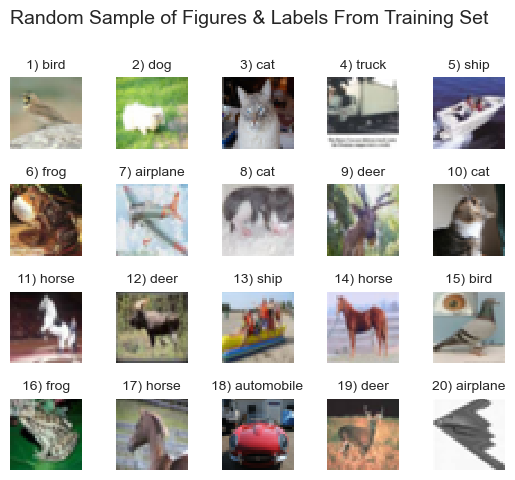

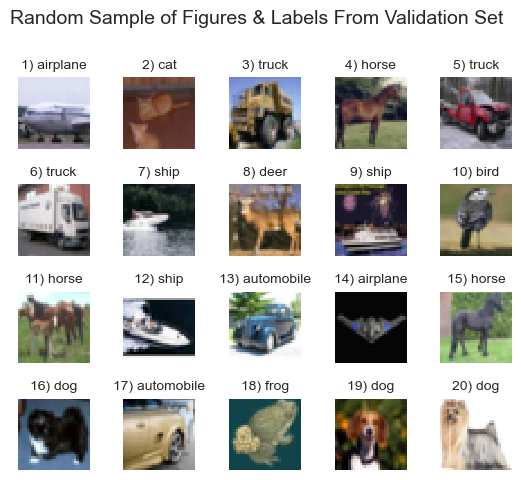

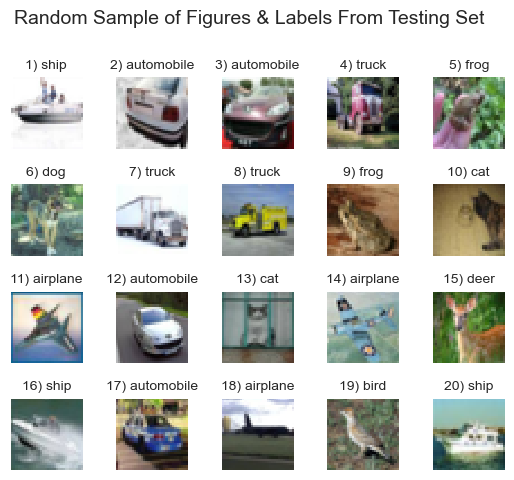

In [9]:
from numpy import random

def display_random_images(x_data , y_label , data_type:str , n_rows = 4, n_cols = 5):
    p = plt.figure(figsize=(n_cols * 1.3, n_rows * 1.3))
    ## loop through rows and cols 
    for row in range(n_rows):
        for col in range(n_cols):
            ## image location
            index = n_cols * row + col
            ## generate random index
            img_index = random.randint(0 , len(y_label))
            ## Add to subplot
            p = plt.subplot(n_rows, n_cols, index + 1)
            ## select image to show 
            p = plt.imshow(x_data[img_index], cmap="binary", interpolation="nearest")
            p = plt.axis('off')
            ## add image title 
            p = plt.title( str(index + 1) + ") " + class_names[y_label[img_index]], fontsize=10)
    ## Adjust the spacing for the subplot & Show 
    p = plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle("Random Sample of Figures & Labels From {} Set".format(data_type  ),  y=1.01 , fontsize=14)
    p = plt.show()


## Plot random sample for each dataset 
display_random_images(X_train_sm, y_train_sm, "Training")
display_random_images(X_val, y_val , "Validation")
display_random_images(X_test, y_test , "Testing")

# Utility Functions 

In [10]:
def fit_model(model, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val)
                        )
    return history


def fit_best_model_early_stopping(model, epochs=1):
    # Best LR schedule from MLP
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.1
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
    history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping_cb, lr_scheduler])
    return history


## Model Saving, Loading, Utility Functions

In [11]:
def check_model_exists(name):
    import os.path
    return os.path.exists(name + ".h5")

def save_model(model , name ):
    model.save(name + ".h5")

def load_model(name):
    return keras.models.load_model(name + ".h5")

def delete_model(file):
    import os
    if os.path.exists(file + ".h5"):
         os.remove(file + ".h5")
    if os.path.exists(file + ".npy"):
         os.remove(file + ".npy")

def delete_all_models():
    import os, shutil
    for folder in ["./Smith_David-MLP" ,"./Smith_David-CNN" ]:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

def evaluate_model(model):
    model.evaluate(X_test, y_test)

def save_history(history, name):
    np.save(name + '.npy' , history.history)
    print("Saved history")

def load_history(name):
    return np.load( name + '.npy',allow_pickle='TRUE').item()

def plot_history(history):
    pd.DataFrame(history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.suptitle("Training History",  y=1.01 , fontsize=14)
    plt.show()
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Model Evaluation Function

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix 

## Plot sample of predictions 
def show_sample_prediction(x_data , y_data, y_pred ):
  plt.figure(figsize=(14, 8))
  for index, image in enumerate(x_data):
      plt.subplot(3, 4, index + 1)
      plt.imshow(image, cmap="binary", interpolation="nearest")
      plt.axis('off')
      colour = "b" if y_pred[index] == y_data[index] else "r"

      plt.title("Prediction: {0} \n Actual: {1}".format(class_names[y_pred[index]], class_names[y_data[index]]), color=colour, fontsize=12)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.suptitle("Sample of Model Predictions & Actual Labels" ,  y=1.01 , fontsize=18)
  plt.show()

## Function that creates a confusion matrix plot 
def create_confusion_plot(conf_mx , y_values , name =""):
  ## Format the value from matrix
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_mx .flatten()]
                  
  ## Get the percentage of represented in each cell
  group_percentages = ["{0:.2%}".format(value) for value in
                      conf_mx .flatten()/np.sum(conf_mx )]
  ## Create Text Labels 
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]

  ## Reshape the array into a data frame 
  n_classes = len(np.unique(y_values))
  labels = np.asarray(labels).reshape(n_classes , n_classes)

  ## Create colour palette
  cmap = 'Blues'

  ## Create new plot
  plt.figure() 
  ## Create heatmap
  # res = sns.heatmap(conf_mx , annot=labels ,fmt='',  vmin=0.0, vmax= 100.0,  cmap=cmap)
  res = sns.heatmap(conf_mx , annot=labels ,fmt='',     cmap=cmap)

  # labels, title and ticks
  res.set_xlabel('Predicted labels')
  res.set_ylabel('True labels')
  res.set_title(name + " Class Confusion Matrix", fontsize=18)
  res.xaxis.set_ticklabels( [class_names[i] for i in  np.unique(y_values)] )
  res.yaxis.set_ticklabels([class_names[i] for i in  np.unique(y_values)] )
  plt.yticks(rotation=0) 
  plt.plot()

## Function to quickly create model evaluations 
def evaluate_metrics(model, x_data , y_data, name=""):
    print("\n\n---------------------------- Model Results ----------------------------\n")
    ## Create Prediction from testing data 
    y_prob = model.predict(x_data)
    y_pred = y_prob.argmax(axis=-1)

    ## Calculate individual scores
    print(name , " Precision Score: " , "{0:.2%}".format(precision_score(y_data, y_pred, average="weighted")))
    print(name , " Recall Score: " , "{0:.2%}".format(recall_score(y_data, y_pred, average="weighted")))
    print(name , " F1 Score: " , "{0:.2%}".format(f1_score(y_data, y_pred, average="weighted")))

    ## Classification performance 
    report = classification_report(y_data, y_pred)
    print("\n", name,  " Report:  \n\n" , report)

    ## Create confusion matrix - no need to print as its on the plot
    conf_mx = confusion_matrix( y_data , y_pred )
    create_confusion_plot(conf_mx , y_data,  name )
    show_sample_prediction(x_data[:12] , y_data[:12], y_pred[:12])

## Function to quickly create model evaluations 
def model_grid_eval(model_grid , x_data , y_data, name=""):
    print("\n\n---------------------------- Model Results ----------------------------\n")
    ## Create Prediction from testing data 
    y_pred = model_grid.best_estimator_.predict(x_data)

    ## Calculate individual scores
    print(name , " Precision Score: " , "{0:.2%}".format(precision_score(y_data, y_pred, average="weighted")))
    print(name , " Recall Score: " , "{0:.2%}".format(recall_score(y_data, y_pred, average="weighted")))
    print(name , " F1 Score: " , "{0:.2%}".format(f1_score(y_data, y_pred, average="weighted")))

    ## Classification performance 
    report = classification_report(y_data, y_pred)
    print("\n", name,  " Report:  \n\n" , report)

    ## Create confusion matrix - no need to print as its on the plot
    conf_mx = confusion_matrix( y_data , y_pred )
    create_confusion_plot(conf_mx , name )


# Implementation of MLP 

### Loss Function

**Sparse Categorical Cross-Entropy**

In multi-class classification tasks, categorical crossentropy is a loss function where the outcome can only fit into one of many possible categories, and the model must choose one.

### Optimizer

**SGD**

The iterative approach of stochastic gradient descent is used to optimise an objective function with sufficient smoothness criteria. Because it replaces the actual gradient with an estimate, it can be considered a stochastic approximation of gradient descent optimisation.

Stochastic gradient descent with learning rate and momentum as trainable hyperparameters. 

### Hyperparameter 

NOTE: 

For runtime speed, the hyperparameters are tuned using a random grid search through the supplied variables. However, the function allows for a full, exhaustive grid search to be performed if required by passing the argument True to the function. 

**Dropout rate:**

Dropout rate is a popular regularization technique used for neural networks. It works were every neurone (including input neurones but excluding output neurones) has a probability p of being momentarily "dropped out" during each training step, meaning it will be completely ignored during current training phase but may be active during the next.

**Learning rate & momentum:**

The learning rate determines how much the weight is updated at the end of each batch, while the momentum determines how much the prior update influences the current update.

**Kernal Initializer:**

Initializers define the way to set the initial random weights of Keras layers.

Here uniform and normal distributions are used to initialize the values.




### Layers 

Flatten: 
- Input shape [32,32,3]

Dropout 

Dense: 
- Shape: 256
- Activation function: Relu

Dropout 

Dense: 
- Shape: 64
- Activation function: Relu

Dropout 

Dense: 
- Shape: 10
- Activation function: Softmax




In [13]:
def reset_session():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

def initialize_mlp_model(init_mode='uniform', dropout_rate=0.0, learn_rate=0.01, momentum=0.001):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[32, 32, 3]),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(256, kernel_initializer=init_mode,
                           activation="relu"),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, kernel_initializer=init_mode,
                           activation="relu"),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(10, activation="softmax")
    ])
    optimizer = keras.optimizers.SGD(learning_rate=learn_rate,
                     momentum=momentum)
    compile_mlp_model(model, optimizer)
    return model


def compile_mlp_model(model, optimizer):
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

def create_mlp_model():
    return keras.wrappers.scikit_learn.KerasClassifier(build_fn=initialize_mlp_model)

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.callbacks import LearningRateScheduler

def fit_mlp_grid_search(model, epochs=1, n_iter=2, run_full_search=False):
    # Define the grid search parameters
    ## Weight Initialization
    init_mode = ['uniform', 'normal']
    ## Dropout rate
    dropout_rate = [0.0, 0.1, 0.2, 0.5,0.4, 0.5]
    ## Learning rate & momentum for optimizer
    learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
    momentum = [0.001, 0.2, 0.4, 0.6]
    ## Setup grid
    param_grid = dict(
                      dropout_rate=dropout_rate,
                      init_mode=init_mode, 
                      learn_rate=learn_rate, 
                      momentum=momentum
                      )
    ## check if full or random search
    if run_full_search:
        grid = GridSearchCV(
            model, param_grid,  cv=3)
    else:
        grid = RandomizedSearchCV(
            model, param_grid,  n_iter= n_iter, cv=2 )
    print(grid)
    #fit the grid search
    grid_result = grid.fit(X_train,
                           y_train,
                           epochs=epochs,
                           validation_data=(X_val, y_val))
    ## Print results
    summarize_grid_results(grid_result)
    ## Return the best model
    return grid_result.best_estimator_

def summarize_grid_results(grid_result, show_all=False):
    # summarize results
    print("Best: %f using %s" %
          (grid_result.best_score_, grid_result.best_params_))
    ## print outcome of all tests
    if show_all:
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))


## ---------------------- Further Grid Search Function on for Reference ----------------------  ##

def step_decay(epoch):
    import math
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def grid_search_learning_rate_momentum(model, X, Y):
    # define the grid search parameters
    learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
    momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    param_grid = dict(learn_rate=learn_rate, momentum=momentum)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    ## Print results
    summarize_grid_results(grid_result)
    return grid_result.best_estimator_

def grid_search_init_mode(model, X, Y):
    # define the grid search parameters
    init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero',
                 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    param_grid = dict(init_mode=init_mode)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    ## Print results
    summarize_grid_results(grid_result)
    return grid_result.best_estimator_

def drop_out_rate_init(model, X, Y):
    # define the grid search parameters
    weight_constraint = [1, 2, 3, 4, 5]
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    param_grid = dict(dropout_rate=dropout_rate,
                      weight_constraint=weight_constraint)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    ## Print results
    summarize_grid_results(grid_result)
    return grid_result.best_estimator_

def number_neurons_init(model, X, Y):
    # define the grid search parameters
    neurons = [1, 5, 10, 15, 20, 25, 30]
    param_grid = dict(neurons=neurons)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    ## Print results
    summarize_grid_results(grid_result)
    return grid_result.best_estimator_


## RUN MLP


**Best Parameters from MLP model training**

- momentum: 0.4  
- learn_rate: 0.01  
- init_mode: uniform  
- dropout_rate: 0.0  


**Early stopping**  

Early stopping has been added to the full training of the best parameters.
This is not implemented in the cross validation phase of hyperparameter tuning however as this could cause close parameters to stop before their optimal value and issues were comparing between parameters that have not been trained through comparable processes. Cross validation is implicitly base on "all other things being equal" and as such it is best not to use early stopping to keep things as comparable as possible. 


**Cross Validation**

Cross validation has been implemented to ensure that hyperparameter training is done with multiple validations. The CV process has been implemented with a random grid however this can be changed to an exhaustive search by updating the boolean value passed to the function. 

**Validation in Training**

Validation set has been incorporated into the grid search to try to reduce the overfitting of the models. 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 803,786
Trainable params: 803,786
Non-trainable params: 0
_________________________________________________________________
1563/1563 [==============================] - 8s 5m

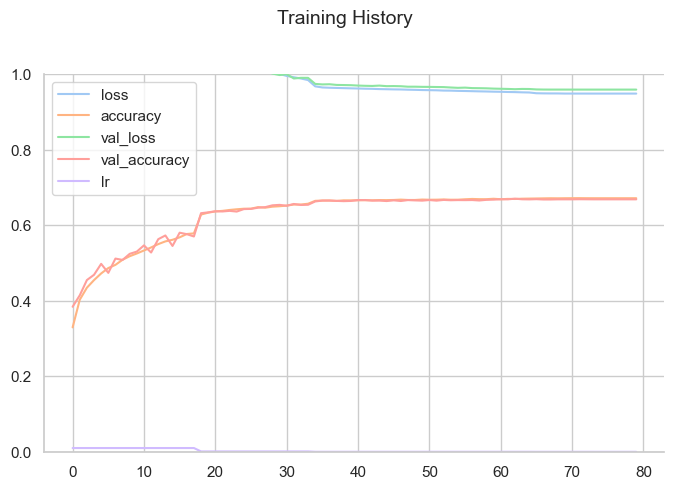



---------------------------- Model Results ----------------------------

Keras MLP Model  Precision Score:  54.69%
Keras MLP Model  Recall Score:  54.92%
Keras MLP Model  F1 Score:  54.75%

 Keras MLP Model  Report:  

               precision    recall  f1-score   support

           0       0.63      0.61      0.62      1000
           1       0.67      0.66      0.66      1000
           2       0.46      0.42      0.44      1000
           3       0.37      0.35      0.36      1000
           4       0.47      0.47      0.47      1000
           5       0.46      0.43      0.44      1000
           6       0.55      0.63      0.59      1000
           7       0.61      0.61      0.61      1000
           8       0.66      0.70      0.68      1000
           9       0.58      0.60      0.59      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



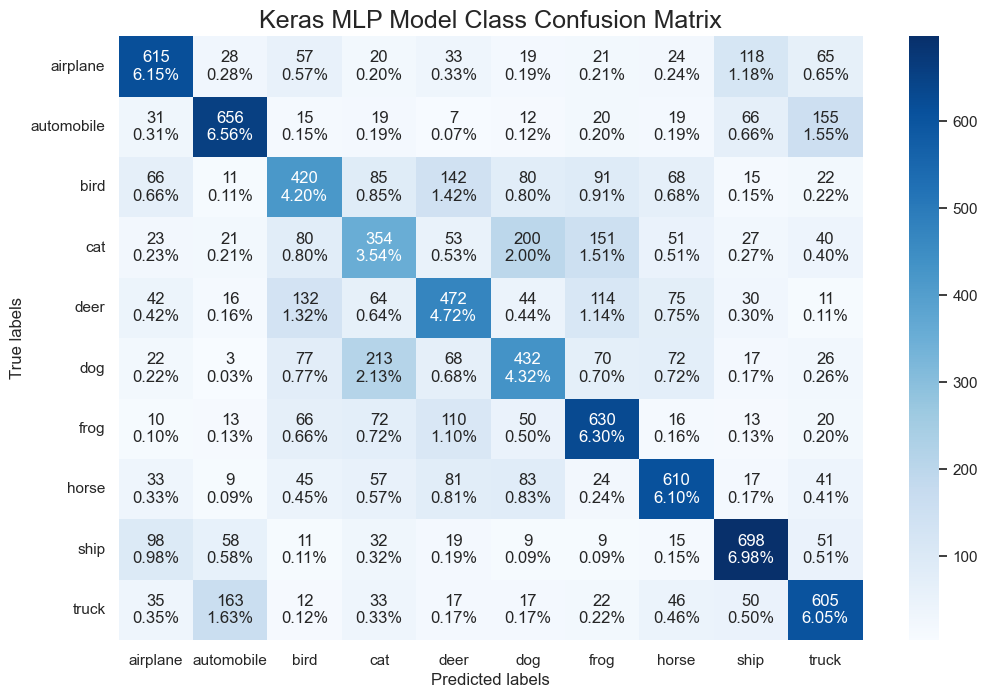

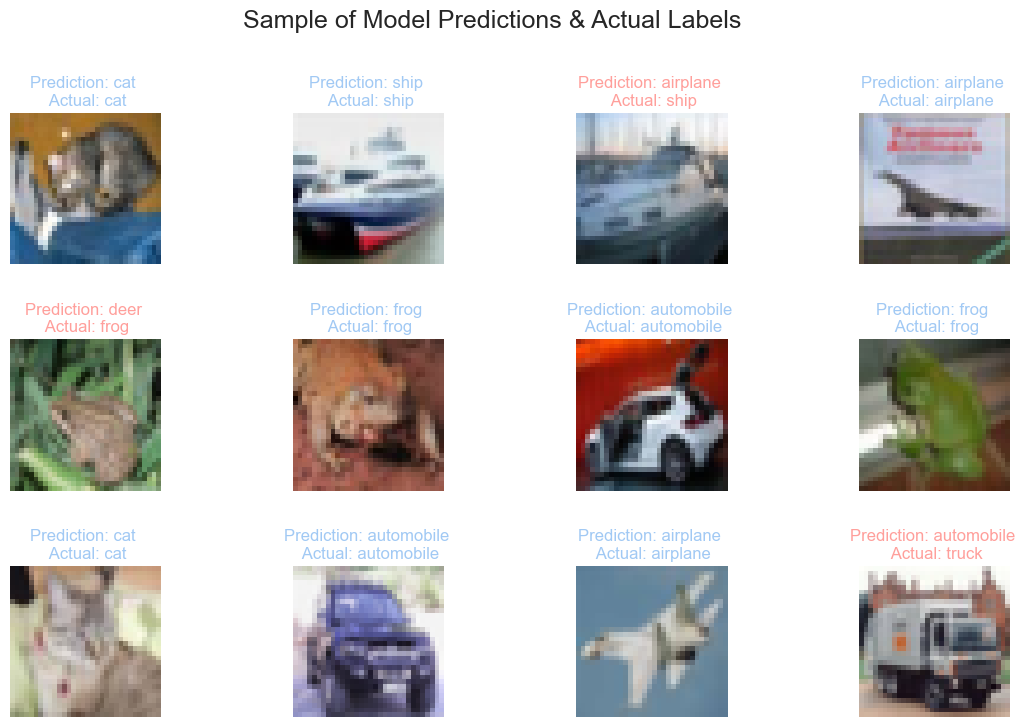

Total Time: 1.2e+01 seconds


In [15]:
mlp_name = "./Smith_David-MLP/Smith_David-MLP"

start=time()

if check_model_exists(mlp_name):
    reset_session()
    ## Load model 
    mlp_model = load_model(mlp_name)
    mlp_model.summary()
    ## Fit model 
    fit_model(mlp_model , epochs=1)
    ## Load history from training run 
    history = load_history(mlp_name)
    ## Plot and Review model 
    plot_history(history)
    evaluate_metrics(mlp_model, X_test, y_test, "Keras MLP Model")
    
else: 
    reset_session()
    ## Create model 
    mlp_model = create_mlp_model()
    ## Fit grid search
    mlp_model = fit_mlp_grid_search(mlp_model, n_iter=5, epochs=10)
    ## Review best model 
    print(mlp_model)
    ## Fit best model with early stopping 
    history = fit_best_model_early_stopping(mlp_model, epochs=100)
    ## Output & Review model 
    save_history(history , mlp_name)
    plot_history(history.history)
    save_model(mlp_model.model , mlp_name)
    evaluate_metrics(mlp_model.model, X_test, y_test, "Keras MLP Model")

print("Total Time: {0:.2} seconds".format(time()-start))

# Implementation of CNN

### Loss Function

**Sparse Categorical Cross-Entropy**


### Optimizer

**SGD**

Stochastic gradient descent with learning rate and momentum set from MLP training 

### Hyperparameter 

NOTE: 

For runtime speed, the hyperparameters are tuned using a random grid search through the supplied variables. However, the function allows for a full, exhaustive grid search to be performed if required by passing the argument True to the function. 


**Number of Kernels**

Number of filter layers. 


**Kernel Size:**
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
Must be an odd number. 

**Activation Function:**
Relu & Sigmoid are tested using the grid search. 


**Dropout rate:**

Set to 0 from MLP model. However this has been left in as the CNN was over-fitting the data and therefore should be reintroduced and trained. 

**Learning rate & momentum:**

The learning rate determines how much the weight is updated at the end of each batch, while the momentum determines how much the prior update influences the current update.

**Kernal Initializer:**

Initializers define the way to set the initial random weights of Keras layers.

Here uniform and normal distributions are used to initialize the values.




### Layers 

Conv2D
- num_kernels: from grid search 
- kernel_size: from grid search 
- activation: from grid search 
- padding="same"
- input_shape=[32, 32, 3]


MaxPooling2D
- pool_size: 2

Conv2D
- num_kernels: from grid search 
- kernel_size: from grid search 
- activation: from grid search 
- padding="same"

MaxPooling2D
- pool_size: 2

Flatten
 
BatchNormalization
 

Dense
- Shape 50, 
- activation='relu'

BatchNormalization

Dense
- Shape 10, 
- activation='softmax'


In [16]:

def initialize_cnn_model(num_kernels=(64, 128), kernel_size=(5, 3), activation_func='relu'):
  model = keras.models.Sequential([
      keras.layers.Conv2D(
          num_kernels[0],
          kernel_size[0],
          activation=activation_func,
          padding="same",
          input_shape=[32, 32, 3]
      ),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Conv2D(
          num_kernels[1],
          kernel_size[1],
          activation=activation_func,
          padding="same"
      ),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Flatten(),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(10, activation='softmax'),
  ])
  optimizer = keras.optimizers.SGD(learning_rate=0.01,
                     momentum=0.4)
  compile_cnn_model(model, optimizer)
  return model

def compile_cnn_model(model, optimizer):
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer, metrics=["accuracy"])

def create_cnn_model(): 
    return keras.wrappers.scikit_learn.KerasClassifier(build_fn = initialize_cnn_model) 

def fit_cnn_grid_search(model, epochs=1, n_iter=2, run_full_search=False):
    ## Define the grid search parameters
    num_kernels = [(64, 128), (128, 256)]
    kernel_size = [(5, 3), (7, 3)]
    activation_func = ["relu", "sigmoid"]
    param_grid = dict(
        num_kernels=num_kernels,
        kernel_size=kernel_size,
        activation_func=activation_func
    )
    ## check if full or random search
    if run_full_search:
        grid = GridSearchCV(
            model, param_grid, cv=2)
    else:
        grid = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=2)
    #fit the grid search
    grid_result = grid.fit(X_train, y_train, epochs=epochs,
                           validation_data=(X_val, y_val))
    ## Print results
    summarize_grid_results(grid_result)
    ## Return the best model
    return grid_result.best_estimator_



# Run CNN

**Best Parameters from MLP model training**

- num_kernels: (128, 256)
- kernel_size: (7, 3)
- activation_func: 'relu



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 128)       18944     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 16384)             0         
                                                                 
 batch_normalization_34 (Bat  (None, 16384)          

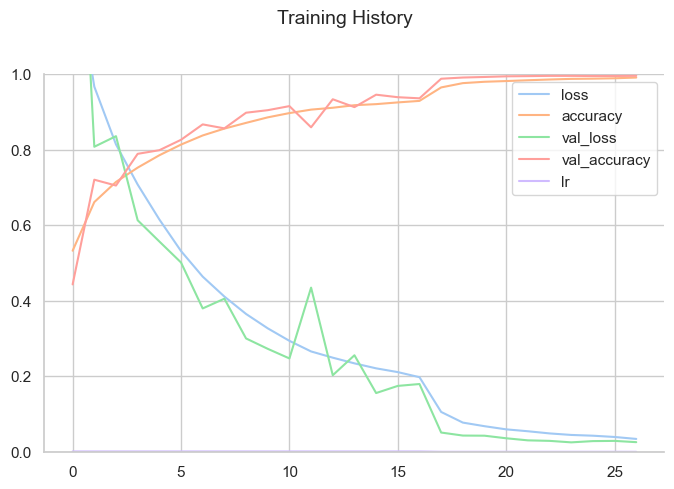



---------------------------- Model Results ----------------------------

Keras CNN Model  Precision Score:  72.81%
Keras CNN Model  Recall Score:  72.85%
Keras CNN Model  F1 Score:  72.81%

 Keras CNN Model  Report:  

               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.86      0.81      0.84      1000
           2       0.64      0.62      0.63      1000
           3       0.54      0.53      0.54      1000
           4       0.67      0.70      0.68      1000
           5       0.65      0.61      0.63      1000
           6       0.76      0.81      0.78      1000
           7       0.77      0.77      0.77      1000
           8       0.85      0.83      0.84      1000
           9       0.81      0.81      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



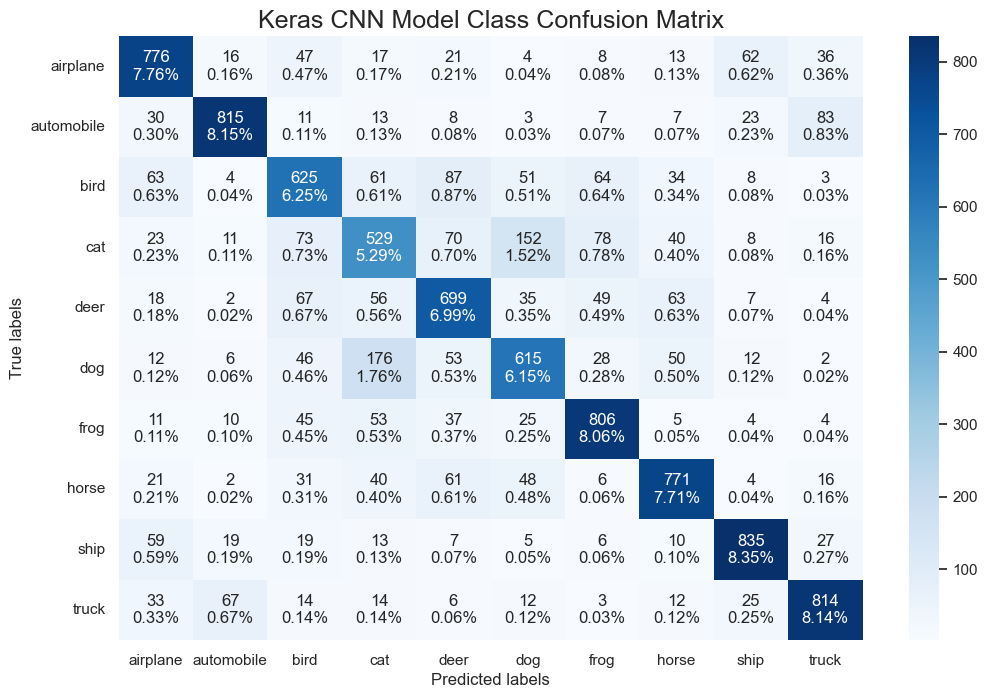

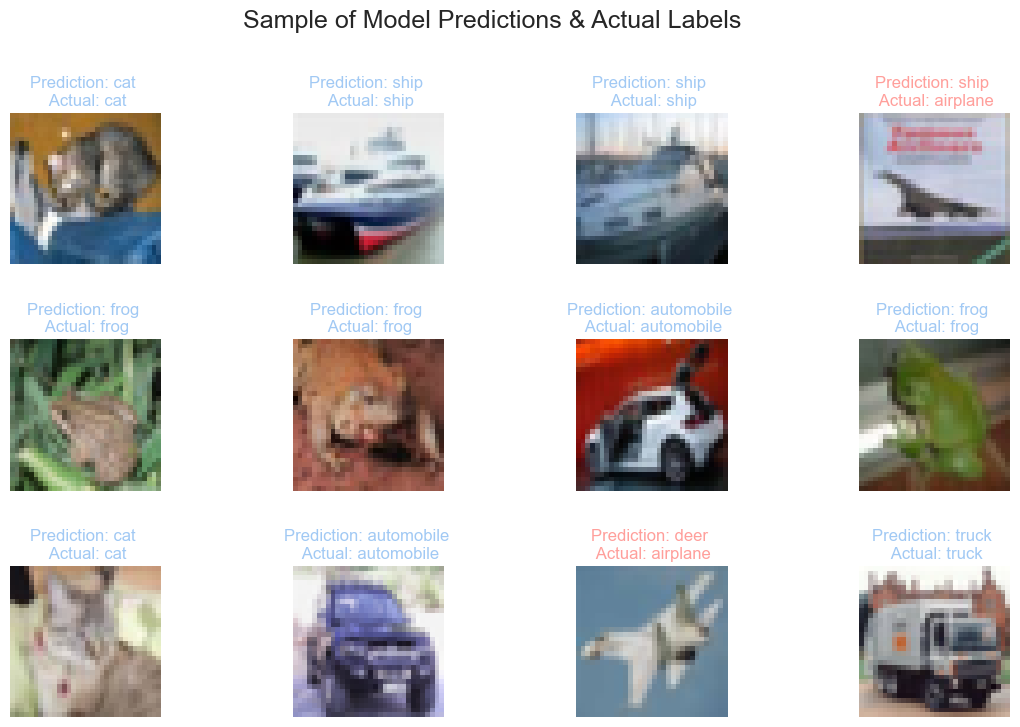

Total Time: 3.9e+01 seconds


In [17]:
cnn_name = "./Smith_David-CNN/Smith_David-CNN"

start=time()

if check_model_exists(cnn_name ):
    reset_session()
    ## Load model 
    cnn_model = load_model(cnn_name )
    cnn_model.summary()
    ## Fit model 
    fit_model(cnn_model , epochs=1)
    ## Load history from training run 
    history = load_history(cnn_name )
    ## Plot and Review model 
    plot_history(history)
    evaluate_metrics(cnn_model, X_test, y_test, "Keras CNN Model")
else: 
    reset_session()
    ## Create model 
    cnn_model = create_cnn_model()
    cnn_model = fit_cnn_grid_search(cnn_model,epochs=10,n_iter=10)
    ## Review best model 
    print(cnn_model)
    ## Fit best model with early stopping 
    history = fit_best_model_early_stopping(cnn_model , epochs=100)
    ## Output & Review model 
    save_history(history , cnn_name )
    plot_history(history.history)
    save_model(cnn_model.model , cnn_name )
    evaluate_metrics(cnn_model.model, X_test, y_test, "Keras CNN Model")
    
print("Total Time: {0:.2} seconds".format(time()-start))

### Model Delete or Folder Reset

In [18]:
## Uncomment to delete last model and history 
# delete_model(mlp_name)
# delete_model(cnn_name)

## Uncomment to delete last model and history 
# delete_all_models()


# Evaluate & Compare models 

Compare and comment on your MLP and CNN models on the test set, in terms of: classification
performance (accuracy, F1 score, precision per class), model complexity (e.g., number of trainable
parameters), and computation time4.
For each model, display also a few correctly classified images and a few failure cases for the test
set.


## Overall Model Analysis & Comparison 

| Name | Trainable of Parameters | Time (mins)| Accuracy | Precision |  Recall | F1 |
|:---: |:---: |:---: |:---: |:---: |:---: |:---: |
| MLP | 803,786 | 10 | 55% |55% | 55% | 55% |
| CNN |  1,166,740 | 36 |73% |73% | 73% | 73% |


The CNN model did a better job of fitting to the data than the MLP model, however, the CNN overfit significantly to the training and validation sets with 99.24% and 99.68% accuracy respectively which fell to 72% on the testing set. 

This is not good and further regularisation measures should be introduced such as dropout rate. However the task stated to use the optimal value from the first training so this has been done.

The CNN model trained significantly slower than the MLP model due to an increase in its training and non training parameters. However this allowed it to fit to the more complex function of the data. 


## Class Prediction 

Both models had quite balanced precision and recall scores for the different types of errors. Only class 6, frog, seemed to have a much higher recall than precision in both models. This is due to the model predicting the class of frog for many dogs, cats and deers. This could be due to the heavy green colours in the images. 

### MLP

The MLP model did a okay job of predicting most classes as seen in the confusion matrix. The main issues in classes were the dog & cat, bird & deer, automobile & truck, ship & airplane. 
These are reasonable things that would be difficult for the model to predict.

### CNN

The CNN model did a pretty good job at distinguishing between classes were the MLP model struggled. However some of the still tricky classes caused trouble such as dog & cat, automobile & truck, ship & airplane, and bird & airplane. 




Below are the key metrics from the models as well as sample of prediction and actual plots. 






---------------------------- Keras MLP Model ---------------------------


---------------------------- Model Results ----------------------------

Keras MLP Model  Precision Score:  54.69%
Keras MLP Model  Recall Score:  54.92%
Keras MLP Model  F1 Score:  54.75%

 Keras MLP Model  Report:  

               precision    recall  f1-score   support

           0       0.63      0.61      0.62      1000
           1       0.67      0.66      0.66      1000
           2       0.46      0.42      0.44      1000
           3       0.37      0.35      0.36      1000
           4       0.47      0.47      0.47      1000
           5       0.46      0.43      0.44      1000
           6       0.55      0.63      0.59      1000
           7       0.61      0.61      0.61      1000
           8       0.66      0.70      0.68      1000
           9       0.58      0.60      0.59      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
w

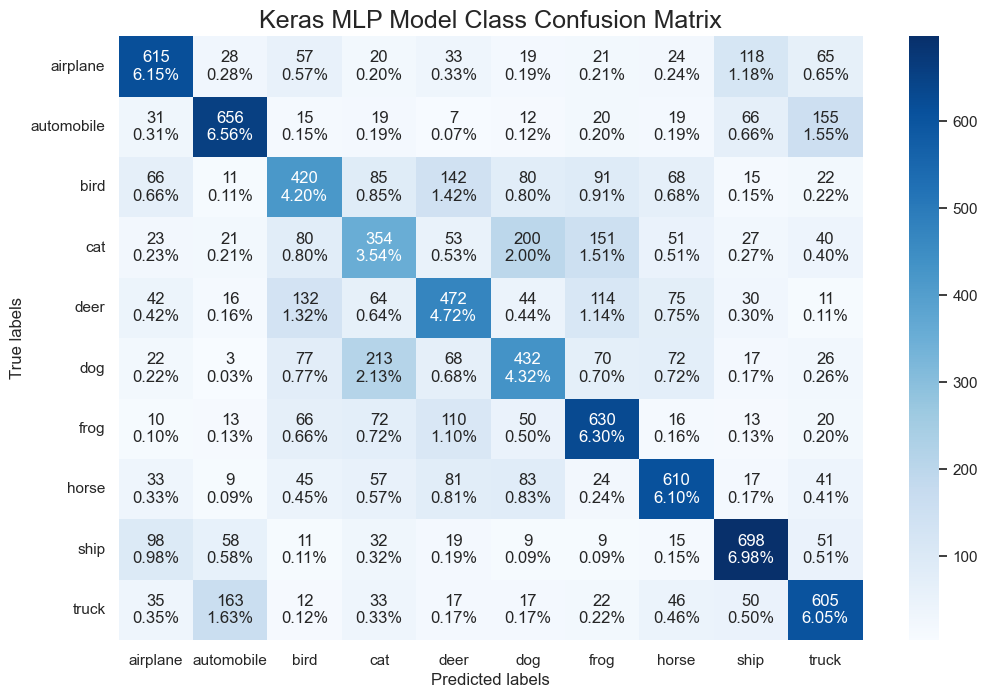

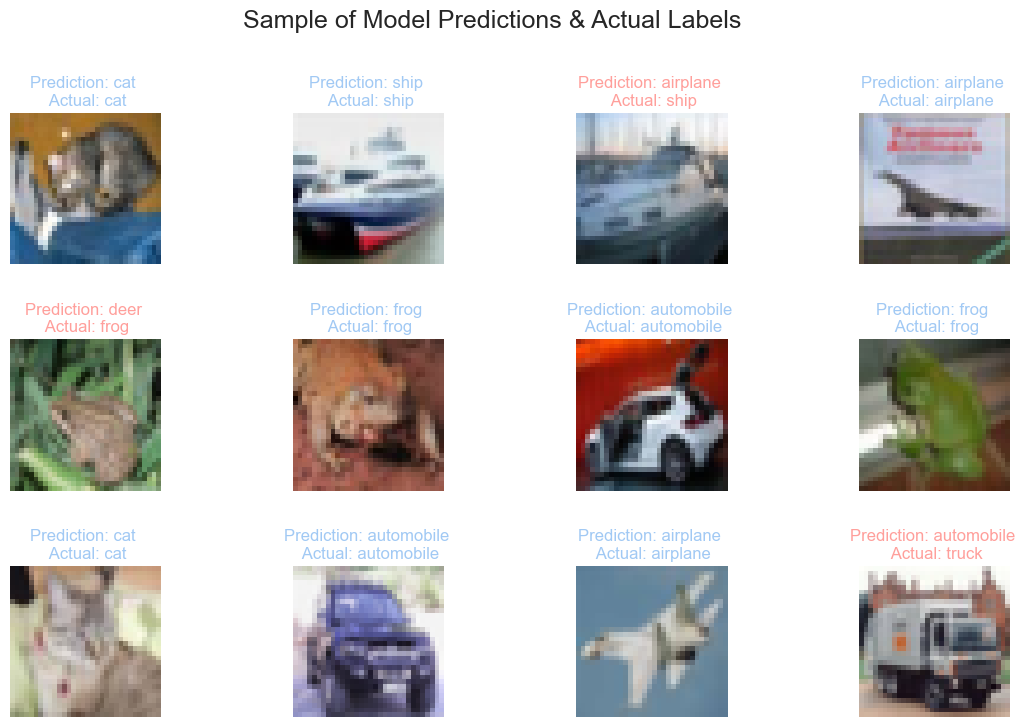

---------------------------- Keras CNN Model ---------------------------


---------------------------- Model Results ----------------------------

Keras CNN Model  Precision Score:  72.81%
Keras CNN Model  Recall Score:  72.85%
Keras CNN Model  F1 Score:  72.81%

 Keras CNN Model  Report:  

               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.86      0.81      0.84      1000
           2       0.64      0.62      0.63      1000
           3       0.54      0.53      0.54      1000
           4       0.67      0.70      0.68      1000
           5       0.65      0.61      0.63      1000
           6       0.76      0.81      0.78      1000
           7       0.77      0.77      0.77      1000
           8       0.85      0.83      0.84      1000
           9       0.81      0.81      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
w

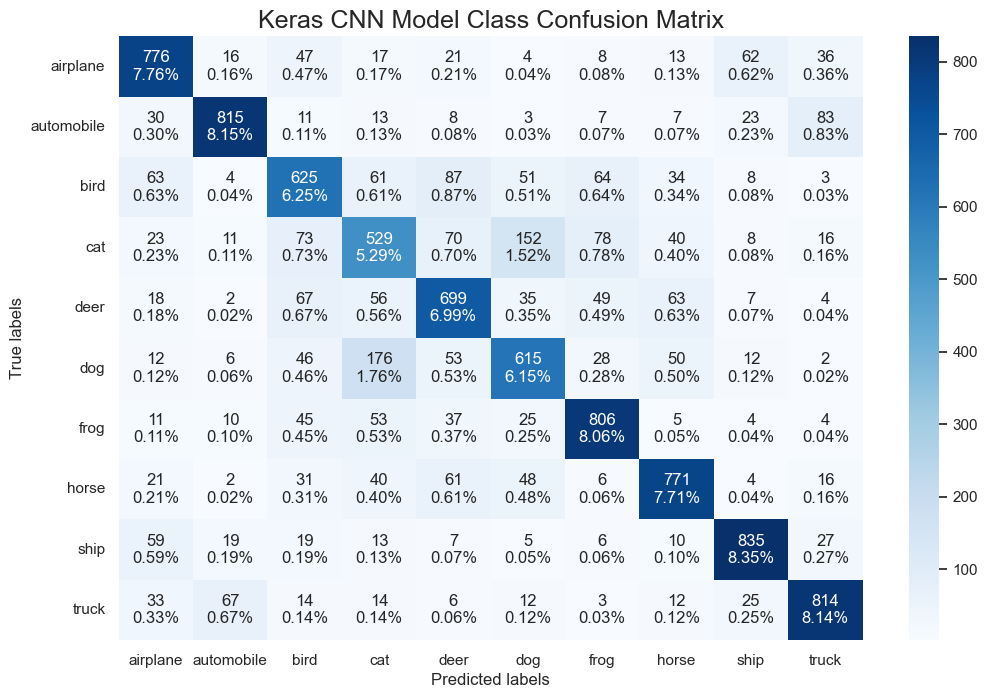

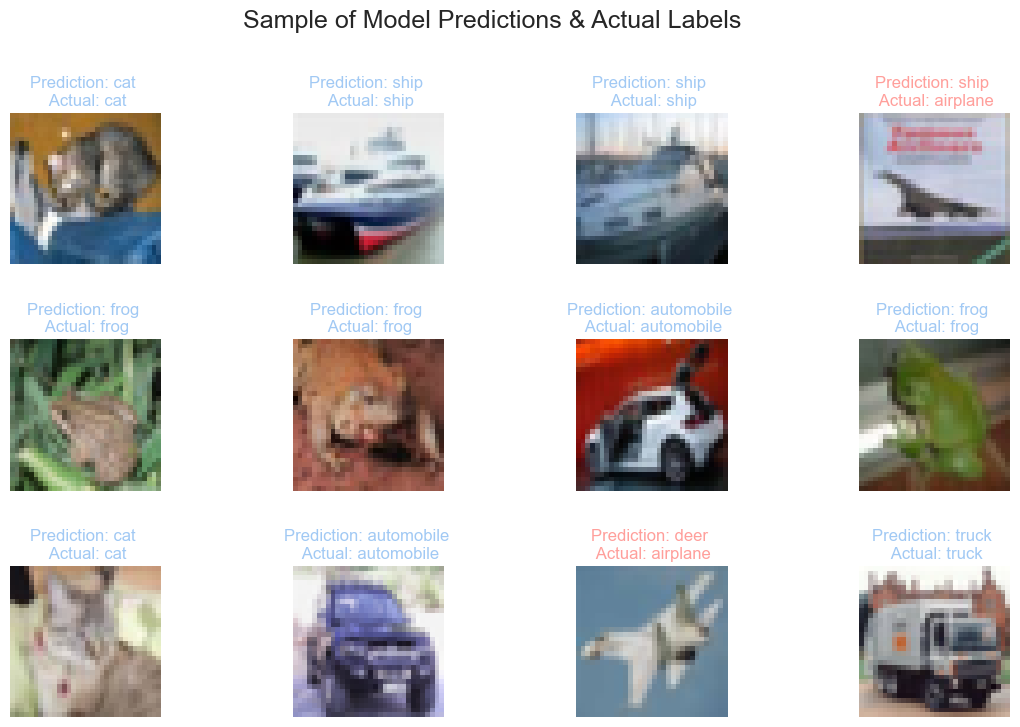

In [19]:
print("---------------------------- Keras MLP Model ---------------------------" )
evaluate_metrics(mlp_model, X_test, y_test, "Keras MLP Model")

print("---------------------------- Keras CNN Model ---------------------------" )
evaluate_metrics(cnn_model, X_test, y_test, "Keras CNN Model")